In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt

from ResNet.ResNet3D import ResNet3D
from medmnist import OrganMNIST3D, Evaluator

In [2]:
# Load data
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

#Load data
train_dataset = OrganMNIST3D(split='train', download=True, size=64)
val_dataset = OrganMNIST3D(split='val', download=True, size=64)
test_dataset = OrganMNIST3D(split='test', download=True, size=64)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)



num_classes = 11
#Alternatively load random
# train_data = torch.randn(1000, 3, 224, 224)  # 1000 random images
# train_labels = torch.randint(0, num_classes, (1000,))  # 1000 random labels
# train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print(train_dataset[0][0].shape, train_dataset[0][1].shape)

Using downloaded and verified file: C:\Users\marga\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\marga\.medmnist\organmnist3d_64.npz
Using downloaded and verified file: C:\Users\marga\.medmnist\organmnist3d_64.npz
(1, 64, 64, 64) (1,)


In [3]:
#Load model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {device}')

models_folder = "models"
model_name = "ResNet3D3463"

model_folder = os.path.join(models_folder, model_name)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)
    print(f"Created folder: {model_folder}")
else:
    print(f"Folder already exists: {model_folder}")

model = ResNet3D([3, 4, 6, 3], num_classes, input_channels=1)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 50

Using: cuda
Created folder: models\ResNet3D3463


Epoch 1 of 50


Epoch 1: Train Loss = 0.9941, Train Acc = 72.09%, Val Loss = 2.8265, Val Acc = 19.88%
Epoch 2 of 50


Epoch 2: Train Loss = 0.4516, Train Acc = 87.64%, Val Loss = 0.6516, Val Acc = 83.85%
Epoch 3 of 50


Epoch 3: Train Loss = 0.3429, Train Acc = 89.80%, Val Loss = 0.5854, Val Acc = 83.23%
Epoch 4 of 50


Epoch 4: Train Loss = 0.1715, Train Acc = 94.54%, Val Loss = 0.1425, Val Acc = 96.89%
Epoch 5 of 50


Epoch 5: Train Loss = 0.1140, Train Acc = 96.19%, Val Loss = 0.1380, Val Acc = 96.27%
Epoch 6 of 50


Epoch 6: Train Loss = 0.0515, Train Acc = 98.66%, Val Loss = 0.0363, Val Acc = 99.38%
Epoch 7 of 50


Epoch 7: Train Loss = 0.0203, Train Acc = 99.69%, Val Loss = 0.0304, Val Acc = 99.38%
Epoch 8 of 50


Epoch 8: Train Loss = 0.0104, Train Acc = 99.79%, Val Loss = 0.0297, Val Acc = 99.38%
Epoch 9 of 50


Epoch 9: Train Loss = 0.0118, Train Acc = 99.79%, Val Loss = 0.0318, Val Acc = 98.76%
Epoch 10 of 50


Epoch 10: Train Loss = 0.0081, Train Acc = 99.79%, Val Loss = 0.0343, Val Acc = 99.38%
Epoch 11 of 50


Epoch 11: Train Loss = 0.0099, Train Acc = 99.79%, Val Loss = 0.0401, Val Acc = 98.76%
Early stopping triggered after epoch 11
Training finished.


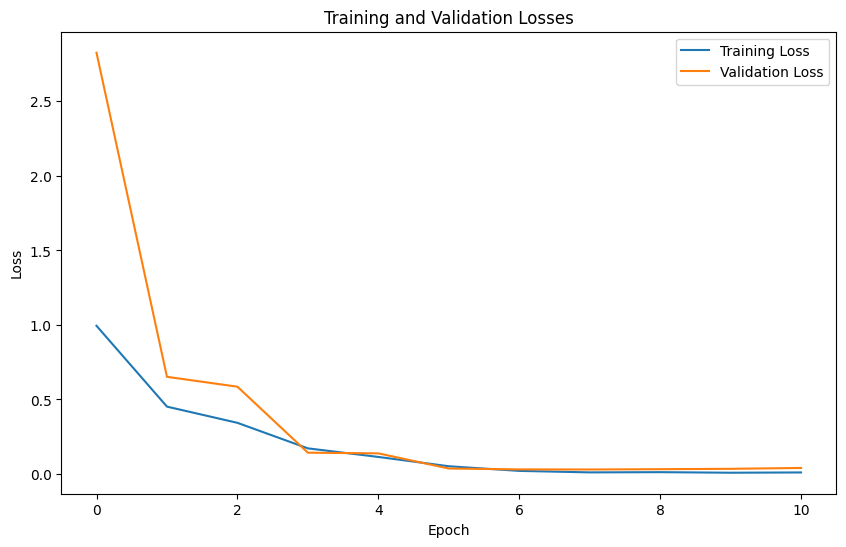

In [6]:
#Train

best_val_loss = float('inf')
best_val_acc = 0
counter = 0
early_stop_threshold = 3
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print("Epoch " + str(epoch+1) + " of " + str(epochs))
    epoch_losses = []
    model.train()
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, leave=False)
    for inputs, targets in progress_bar:
        inputs = inputs.to(device).float()
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs.shape, targets.shape)
        loss = loss_fn(outputs, targets.squeeze())
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets.squeeze()).sum().item()
        
        # Update progress bar
        avg_loss = sum(epoch_losses)/len(epoch_losses)
        train_acc = 100 * correct / total
        progress_bar.set_postfix(
            train_loss=f'{avg_loss:.4f}',
            train_acc=f'{train_acc:.2f}%'
        )
    
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_epoch_losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device).float(), targets.to(device)
            outputs = model(inputs)
            val_loss = loss_fn(outputs, targets.squeeze())
            val_epoch_losses.append(val_loss.item())
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets.squeeze()).sum().item()
    
    avg_val_loss = sum(val_epoch_losses)/len(val_epoch_losses)
    val_acc = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch + 1}: "
          f"Train Loss = {avg_loss:.4f}, Train Acc = {train_acc:.2f}%, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_acc:.2f}%")
    
    # Early stopping check (now using both loss and accuracy)
    if avg_val_loss < best_val_loss and val_acc >= best_val_acc:
        best_val_loss = avg_val_loss
        best_val_acc = val_acc
        counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_loss,
            'val_loss': avg_val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, f'models/{model_name}/best_model.pth')
    else:
        counter += 1
        if counter >= early_stop_threshold:
            print(f'Early stopping triggered after epoch {epoch + 1}')
            break

print("Training finished.")


# Plot training and validation losses
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [7]:
# eval


def test(data_loader):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device).float()
            targets = targets.to(device)
            targets = targets.squeeze()
            outputs = model(inputs)
            _, predictions = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predictions == targets).sum().item()

    return 100 * correct / total

print(f"Test accuracy: {test(test_loader):.2f}")



Test accuracy: 88.52
